In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
sns.set()

from sklearn.svm import SVC
from sklearn import svm, datasets
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

parameters = {}
KERNEL_LINEAR = 1
KERNEL_RBF = 2

DATASET_LINEARLY_SEPARABLE = 1
DATASET_CIRCULAR = 2

In [22]:
def get_data():
    data = np.loadtxt("iris.txt")
    iris_data = data[50:]
    return iris_data 

def get_train_and_test(feature):
    iris_data = get_data()

    positive_data = iris_data[:50, feature]
    positive_data = np.expand_dims(positive_data, axis=2)

    negative_data = iris_data[50:, feature]
    negative_data = np.expand_dims(negative_data, axis=2)

    train_data_positive = positive_data[:25]
    train_data_negative = negative_data[:25]

    test_data_positive = positive_data[25:]
    test_data_negative = negative_data[25:]

    train_data = np.concatenate((train_data_positive, train_data_negative), axis=0)
    test_data = np.concatenate((test_data_positive, test_data_negative), axis=0)

    train_label = [1.0] * len(train_data_positive) + [-1.0] * len(train_data_negative)
    test_label = [1.0] * len(test_data_positive) + [-1.0] * len(test_data_negative)

    train_label_plot = ['positive'] * len(train_data_positive) + ['negative'] * len(train_data_negative)
    test_label_plot = ['positive'] * len(test_data_positive) + ['negative'] * len(test_data_negative)

    return(train_data, test_data, train_label, test_label, train_label_plot, test_label_plot, train_data_positive, train_data_negative, test_data_positive, test_data_negative)

def get_test_and_train(feature):
    iris_data = get_data()

    positive_data = iris_data[:50, feature]
    positive_data = np.expand_dims(positive_data, axis=2)

    negative_data = iris_data[50:, feature]
    negative_data = np.expand_dims(negative_data, axis=2)

    train_data_positive = positive_data[25:]
    train_data_negative = negative_data[25:]

    test_data_positive = positive_data[:25]
    test_data_negative = negative_data[:25]

    train_data = np.concatenate((train_data_positive, train_data_negative), axis=0)
    test_data = np.concatenate((test_data_positive, test_data_negative), axis=0)

    train_label = [1] * len(train_data_positive) + [-1] * len(train_data_negative)
    test_label = [1] * len(test_data_positive) + [-1] * len(test_data_negative)

    train_label_plot = ['positive'] * len(train_data_positive) + ['negative'] * len(train_data_negative)
    test_label_plot = ['positive'] * len(test_data_positive) + ['negative'] * len(test_data_negative)

    return(train_data, test_data, train_label, test_label, train_label_plot, test_label_plot, train_data_positive, train_data_negative, test_data_positive, test_data_negative)

In [40]:
# part1 : linear SVM

feature = [2, 3]

train_data, test_data, train_label, test_label, train_label_plot, test_label_plot, train_data_positive, train_data_negative, test_data_positive, test_data_negative = get_train_and_test(feature)

train_data = np.squeeze(train_data, axis=(2,))
train_label = np.array(train_label)


In [41]:
X = train_data
y = train_label

clf = svm.SVC(kernel='rbf', C=10)
clf.fit(X, y)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

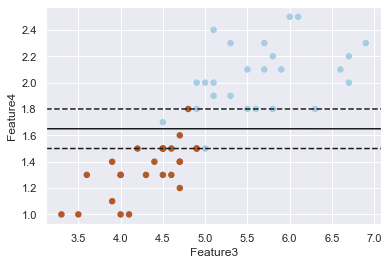

In [42]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
 
# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
 
# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)
 
# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=1, linestyles=['--', '-', '--'])
# plot support vectors
ax.set_xlabel('Feature3')
ax.set_ylabel('Feature4')
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none')
plt.show()

In [43]:
# part1 : linear SVM

feature = [2, 3]

train_data, test_data, train_label, test_label, train_label_plot, test_label_plot, train_data_positive, train_data_negative, test_data_positive, test_data_negative = get_test_and_train(feature)

train_data = np.squeeze(train_data, axis=(2,))
train_label = np.array(train_label)

In [44]:
X = train_data
y = train_label

clf = svm.SVC(kernel='linear', C=100)
clf.fit(X, y)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

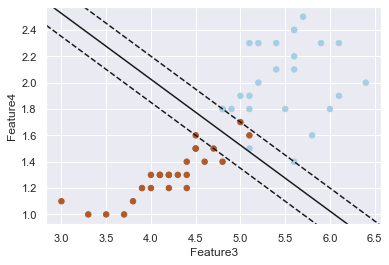

In [45]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
 
# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
 
# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)
 
# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=1, linestyles=['--', '-', '--'])
# plot support vectors
ax.set_xlabel('Feature3')
ax.set_ylabel('Feature4')
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none')
# plt.show()

In [ ]:
# part3 

feature = [2, 3]

train_data, test_data, train_label, test_label, train_label_plot, test_label_plot, train_data_positive, train_data_negative, test_data_positive, test_data_negative = get_train_and_test(feature)

train_data = np.squeeze(train_data, axis=(2,))
train_label = np.array(train_label)

X = train_data
y = train_label

clf = svm.SVC(kernel='linear', C=100)
clf.fit(X, y)